In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


import string
from wordcloud import WordCloud
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split,\
StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahammadmejbah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahammadmejbah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
datasets = pd.read_csv("spam.csv", encoding="latin-1")

In [3]:
datasets.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
datasets.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [5]:
datasets = datasets.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [6]:
datasets.columns

Index(['v1', 'v2'], dtype='object')

In [7]:
datasets = datasets.rename(columns={"v2":"Text",
                                   "v1":"Target"})

In [8]:
datasets.columns

Index(['Target', 'Text'], dtype='object')

In [9]:
datasets.head(10)

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [10]:
datasets.Target.value_counts()

ham     4825
spam     747
Name: Target, dtype: int64

In [11]:
a = datasets[datasets["Target"] == "spam"].iloc[0].Text.lower()
print("Orginal Sentence: \n", a)
print("\n")
print("After Tokenization: \n", nltk.word_tokenize(a))

Orginal Sentence: 
 free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's


After Tokenization: 
 ['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005.', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'question', '(', 'std', 'txt', 'rate', ')', 't', '&', 'c', "'s", 'apply', '08452810075over18', "'s"]


In [12]:
ham_words = ""
spam_words = ""

for i in datasets[datasets["Target"] == "spam"].Text:
    text = i.lower()
    token = nltk.word_tokenize(text)
    for individual_words in token:
        spam_words = spam_words + individual_words + " "
        
        
for i in datasets[datasets["Target"] == "ham"].Text:
    text = i.lower()
    token = nltk.word_tokenize(text)
    for individual_words in token:
        ham_words = ham_words + individual_words + " "

In [13]:
ham_words_wordCloud = WordCloud(width = 500,
                               height = 500).generate(ham_words)

spam_words_wordCloud = WordCloud(width = 500,
                                height = 500).generate(spam_words)

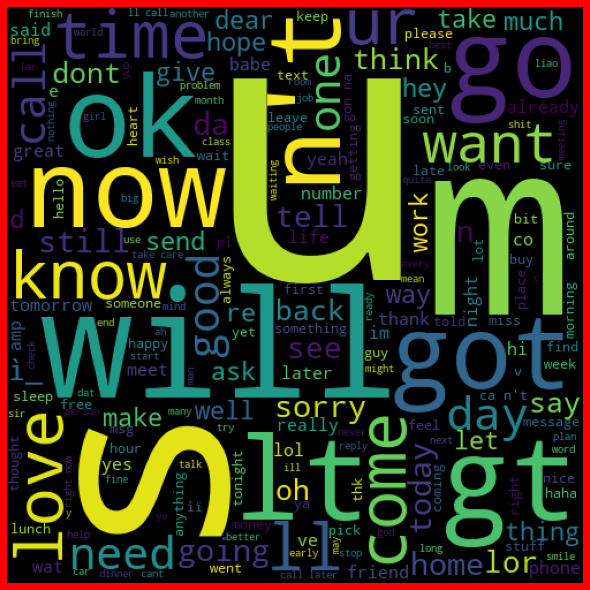

In [14]:
plt.figure(figsize=(10, 8), facecolor="r")
plt.imshow(ham_words_wordCloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

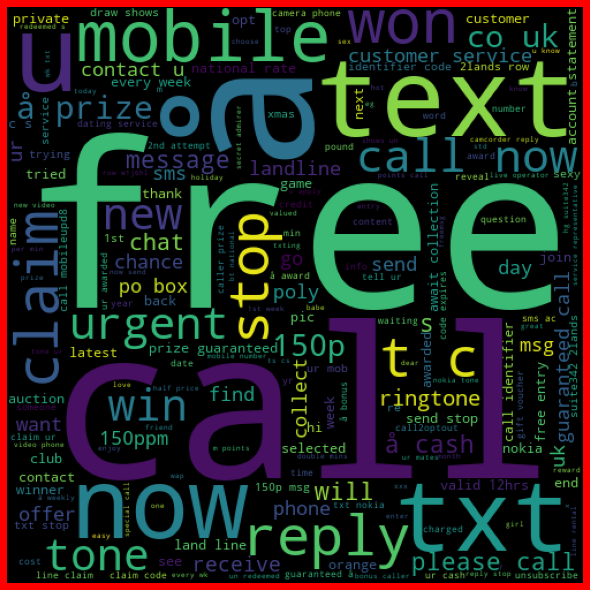

In [15]:
plt.figure(figsize=(10, 8), facecolor="r")
plt.imshow(spam_words_wordCloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [16]:
datasets = datasets.replace(["ham", "spam"], [0, 1])

In [17]:
datasets.head()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
def cleanTextDatasetColumns(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [19]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
cleanTextDatasetColumns("Free entry! #$%&\()*+,-./:;<=>?@[\\]^_{|}~ in 2 a wkly comp to win FA Cup fina.")

'Free entry 2 wkly comp win FA Cup fina'

In [21]:
text = pd.DataFrame(datasets['Text'])
labels = pd.DataFrame(datasets['Target'])

In [22]:
total_count = Counter()
for i in range(len(text)):
    for individual_word in text.values[i][0].split(" "):
        total_count[individual_word] +=1
print("Total Number of Words is : {}".format(len(total_count)))

Total Number of Words is : 15586


In [23]:
text.values[0]

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
      dtype=object)

In [24]:
text.values[0][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [25]:
vocabulary  = sorted(total_count, key=total_count.get, reverse=True)

In [26]:
vocabulary_size = len(vocabulary)
word2idx = {}
for k, v in enumerate(vocabulary):
    word2idx[v] = k

In [27]:
def text_to_vector(text):
    word_vector = np.zeros(vocabulary_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)]+=1
    return np.array(word_vector)

In [28]:
text_to_vector(text.iloc[0][0])

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
word_vector = np.zeros((len(text), len(vocabulary)), dtype = np.int_)

In [30]:
for i, (_, text_) in enumerate(text.iterrows()):
    word_vector[i] = text_to_vector(text_[0])

In [31]:
word_vector

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1]])

In [32]:
word_vector.shape

(5572, 15586)

In [33]:
# term frequency idf [inverse documnets frequency]
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(datasets['Text'])

In [34]:
vectors.shape

(5572, 8672)

In [35]:
datasets.head(1)

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."


In [36]:
features = vectors

In [37]:
x_train, x_test, y_train, y_test = train_test_split(features, datasets["Target"],
                                                   test_size=0.2, 
                                                   random_state=42)

### Decision Tree Classifier

In [38]:
decisionT = DecisionTreeClassifier(min_samples_split=7, random_state=42)
decisionT.fit(x_train, y_train)
decisionT_pred = decisionT.predict(x_test)
print("Accuracy of Decision Tree Classifier {}%".format(round(accuracy_score(y_test, decisionT_pred), 2)))

Accuracy of Decision Tree Classifier 0.97%


### MultiNomial Naive Bayes

In [39]:
naiveB = MultinomialNB(alpha=0.01)
naiveB.fit(x_train, y_train)
naiveB_pred = naiveB.predict(x_test)
print("Accuracy of MultiNomial Naive Bayes Classifier {}%".format(round(accuracy_score(y_test, naiveB_pred), 2)))

Accuracy of MultiNomial Naive Bayes Classifier 0.98%


### Random Forest Classifier

In [40]:
randomForestC = RandomForestClassifier(n_estimators=30, random_state = 42)
randomForestC.fit(x_train, y_train)
randomForestC_pred = randomForestC.predict(x_test)
print("Accuracy of Random Forest Classifier Classifier {}%".format(round(accuracy_score(y_test, randomForestC_pred), 2)))

Accuracy of Random Forest Classifier Classifier 0.98%


### Logistic Regression

In [41]:
logisticR = LogisticRegression(solver="liblinear", penalty='l1')
logisticR.fit(x_train, y_train)
logisticR_pred = logisticR.predict(x_test)
print("Accuracy of Logistic Regression Classifier Classifier {}%".format(round(accuracy_score(y_test, logisticR_pred), 2)))

Accuracy of Logistic Regression Classifier Classifier 0.96%


### Support Vector Classifier

In [42]:
svC = SVC(kernel= "sigmoid",gamma = 0.1)
svC.fit(x_train, y_train)
svC_pred = svC.predict(x_test)
print("Accuracy of Logistic Regression Classifier Classifier {}%".format(round(accuracy_score(y_test, svC_pred), 2)))

Accuracy of Logistic Regression Classifier Classifier 0.94%


In [43]:
def predictedResult(inputUncertainData):
    if inputUncertainData == 1:
        return "SPAM"
    else:
        return "HAM"

uncertainData = ["Please Call"]
vectorsU = vectorizer.transform(uncertainData)
inputUncertainData = svC.predict(vectorsU)
predictedResult(inputUncertainData)

'HAM'

In [44]:

inputUncertainData = naiveB.predict(vectorsU)
predictedResult(inputUncertainData)

'HAM'

In [45]:
inputUncertainData = logisticR.predict(vectorsU)
predictedResult(inputUncertainData)

'SPAM'

In [46]:
inputUncertainData = decisionT.predict(vectorsU)
predictedResult(inputUncertainData)

'HAM'

In [47]:
inputUncertainData = randomForestC.predict(vectorsU)
predictedResult(inputUncertainData)

'HAM'

In [48]:
"a"+"_b"

'a_b'

In [49]:
modelsCollections = {"svC":svC,
                     "decisionT":decisionT,
                     "randomForestC":randomForestC,
                     "logisticR":logisticR,
                     "naiveB":naiveB}


uncertainData = input("Please Enter Your Mail")
print("\nYour Receiving Mail is {}".format(uncertainData))
uncertainData = [uncertainData]
vectorsU = vectorizer.transform(list(uncertainData))

model_Result = []
model_Class = []
for modelKey, modelName in modelsCollections.items():
    # Model Call 
    model = modelName
    #Model Fit
    model.fit(x_train, y_train)
    #Model Predict
    inputUncertainData = modelName.predict(vectorsU)
    modelPredict = modelName.predict(x_test)
    modelAccuracy = round(accuracy_score(y_test, modelPredict), 2)
    model_Result.append(modelAccuracy)
    output = predictedResult(inputUncertainData)
    model_Class.append(output)
    print("The Model of {} Accuracy is {}% \nThe Result of {} Model Classifier is: {}".format(modelKey, modelAccuracy,modelKey,output))


Please Enter Your Mail Please Call



Your Receiving Mail is Please Call
The Model of svC Accuracy is 0.94% 
The Result of svC Model Classifier is: HAM
The Model of decisionT Accuracy is 0.97% 
The Result of decisionT Model Classifier is: HAM
The Model of randomForestC Accuracy is 0.98% 
The Result of randomForestC Model Classifier is: HAM
The Model of logisticR Accuracy is 0.96% 
The Result of logisticR Model Classifier is: SPAM
The Model of naiveB Accuracy is 0.98% 
The Result of naiveB Model Classifier is: HAM


In [50]:
print("\nBest Model Accuracy is : {}%".format(np.max(model_Result)))
from collections import Counter
print("Duplicate Result is {}".format(Counter(model_Result)))
dup = Counter(model_Result)
print(np.max(list(dup.values())))


Best Model Accuracy is : 0.98%
Duplicate Result is Counter({0.98: 2, 0.94: 1, 0.97: 1, 0.96: 1})
2


In [51]:
print(model_Result)
print(model_Class)

[0.94, 0.97, 0.98, 0.96, 0.98]
['HAM', 'HAM', 'HAM', 'SPAM', 'HAM']


In [52]:
for i in model_Class:
    if i == "SPAM":
        ind = model_Class.index("SPAM")
        modelsNamesUpdate = list(modelsCollections.keys())
        print("Correctly Predicted Class is:\t \"{}\" \nThe model is:\t\t\t{} \nThe model accuracy is:\t\t{}".format(i,  modelsNamesUpdate[ind], model_Result[ind]))

Correctly Predicted Class is:	 "SPAM" 
The model is:			logisticR 
The model accuracy is:		0.96
